## RNAseq analysis using DESeq2 package in R
Biancamaria Florenzi, r0777934

The R package DESeq2 is used to identify upregulated and downregulated genes with significance.

In [1]:
library("DESeq2")
library(scales)
options(repr.plot.width=4, repr.plot.height=3)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [2]:
setwd("/mnt/storage/r0777934/jupyternotebooks/Assignment_1")
getwd()

[1] "/mnt/storage/r0777934/jupyternotebooks/Assignment_1"

In [3]:
matrixFile = path.expand("/mnt/storage/r0777934/jupyternotebooks/Assignment_1/all.trimmed.gene.counts")
#taking from the file we have created 

In [21]:
count((rowSums(countData)==0)==TRUE)+count((rowSums(countData)==0)==FALSE)
nrow(countData)

[1] 41863

[1] 41863

In [23]:
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
colnames(countData) <- c("ctrl1", "ctrl2", "flmb1", "flmb2") 
nrow(countData)
countData=countData[rowSums(countData)!=0,]

[1] 41863

[1] 21906

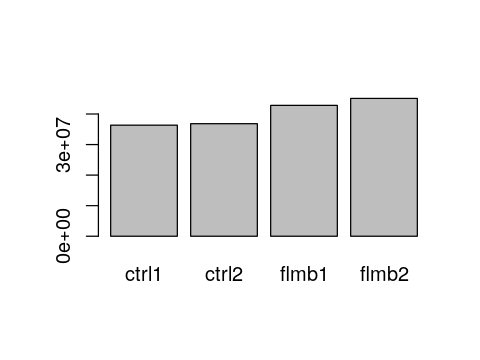

In [24]:
barplot(colSums(countData))

In [25]:
condition <- factor(c("CT", "CT", "KO", "KO"))
print(condition)

[1] CT CT KO KO
Levels: CT KO


In [26]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData

sampleName,condition
<fct>,<fct>
ctrl1,CT
ctrl2,CT
flmb1,KO
flmb2,KO


In [27]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
colnames(dds) <- colnames(countData)

In [28]:
dds

class: DESeqDataSet 
dim: 21906 4 
metadata(1): version
assays(1): counts
rownames(21906): MIR1302-11 RP11-34P13.7 ... AC134878.1 GOLGA2P2Y
rowData names(0):
colnames(4): ctrl1 ctrl2 flmb1 flmb2
colData names(2): sampleName condition

In [29]:
dds$condition

[1] CT CT KO KO
Levels: CT KO

## Running and exploring the differential expression
We use the DESeq function to fit the statistical model to our data of counts.

In [30]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



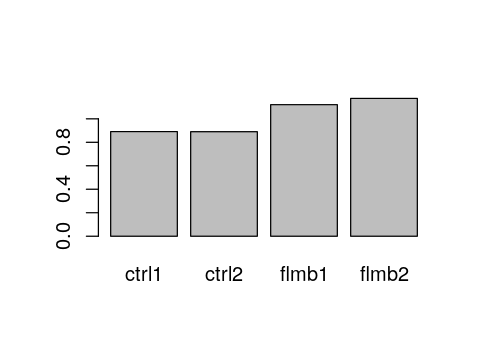

In [31]:
options(repr.plot.width=4, repr.plot.height=3)
barplot(sizeFactors(dds))

In [32]:
sizeFactors(dds)

ctrl1     ctrl2     flmb1     flmb2 
0.8911034 0.8902330 1.1204844 1.1738637

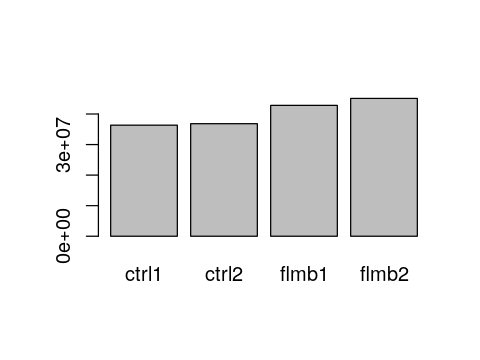

In [33]:
barplot(colSums(countData))

### MA plot
This plot shows the mean expression vs the log fold change and is a very common method to visualize the results of a differential expression plot. Significantly differentially expressed genes are colored red:

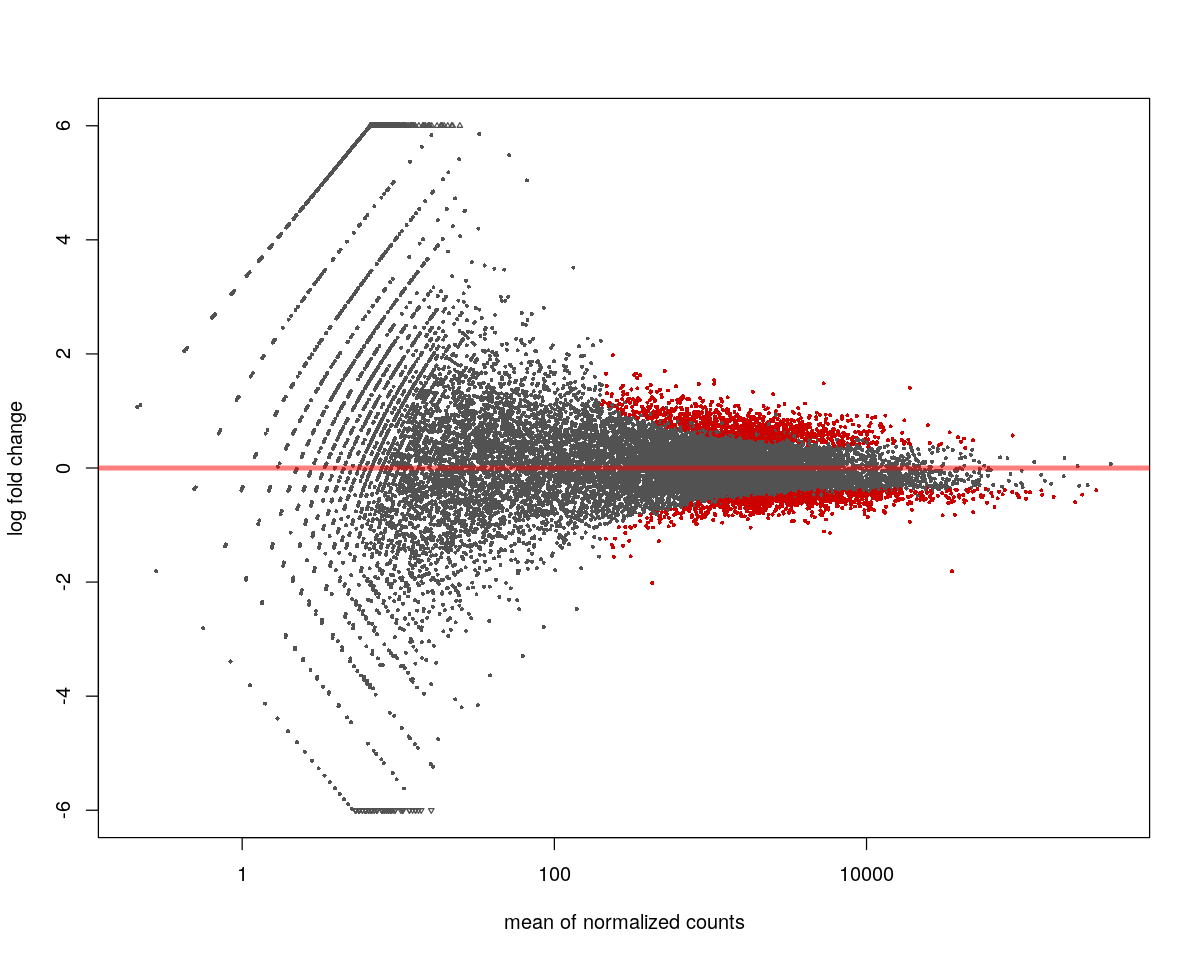

In [35]:
options(repr.plot.width=10, repr.plot.height=8)
plotMA(dds,ylim=c(-6,6))

### Dispersion plot
In this plot the red line represents the global trend of the dispersion compared to the mean of normalised counts.

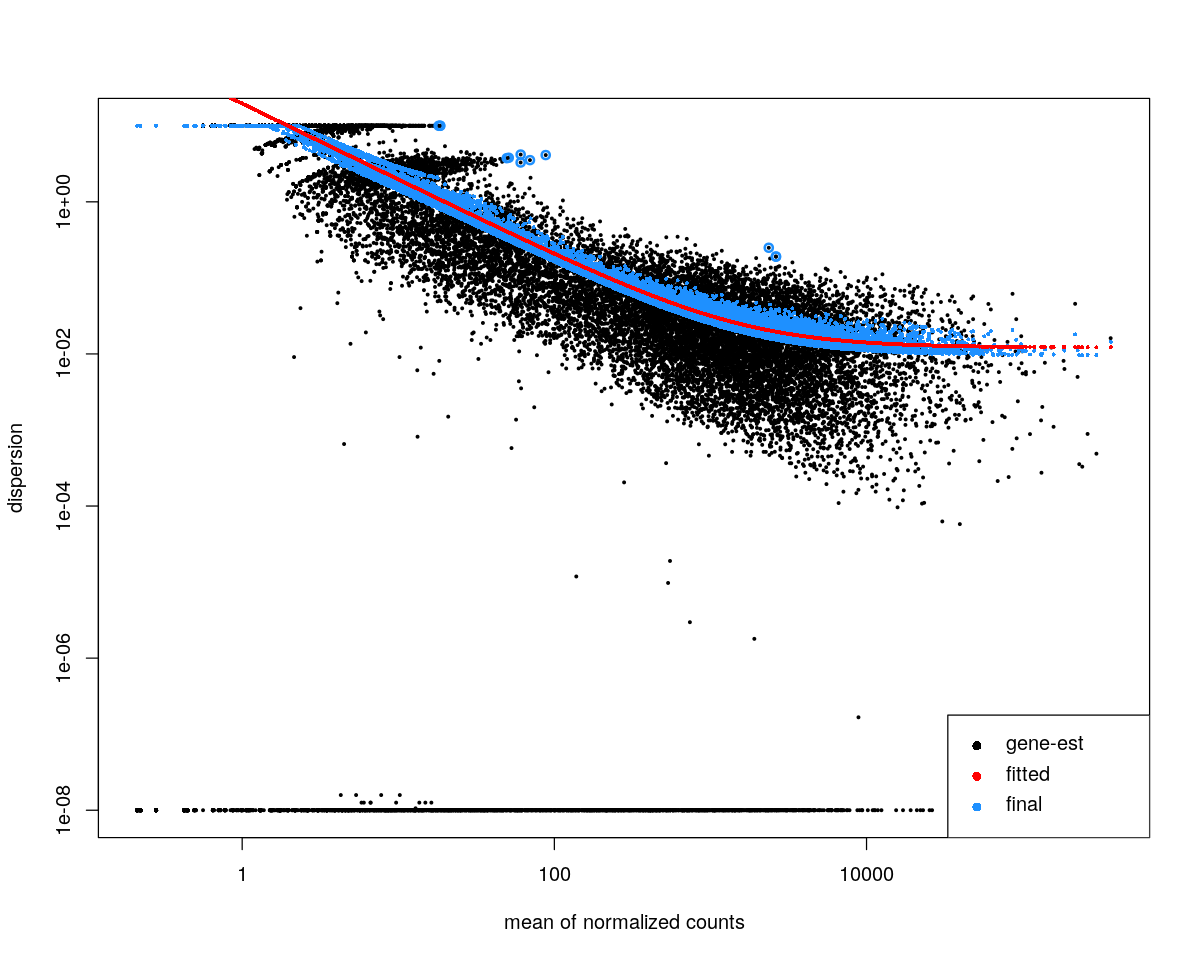

In [67]:
plotDispEsts(dds)

## Evaluating the results
The results function extract a result table from the differential expression analysis.

In [100]:
res <- results(dds)
#res <- res[order(res$padj),]
summary(res)


out of 21906 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1072, 4.9%
LFC < 0 (down)     : 948, 4.3%
outliers [1]       : 0, 0%
low counts [2]     : 11467, 52%
(mean count < 201)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



I also perform a schrinkage with the lfcShrink function and plot it as well in a MA plot. The shrinkage is useful to reduce the noise that comes from lowly expressed genes; the plot now assumes the classical shape of a MA plot.

In [127]:
res_shr <- lfcShrink(dds, contrast=c("condition","CT", "KO"), res=res)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



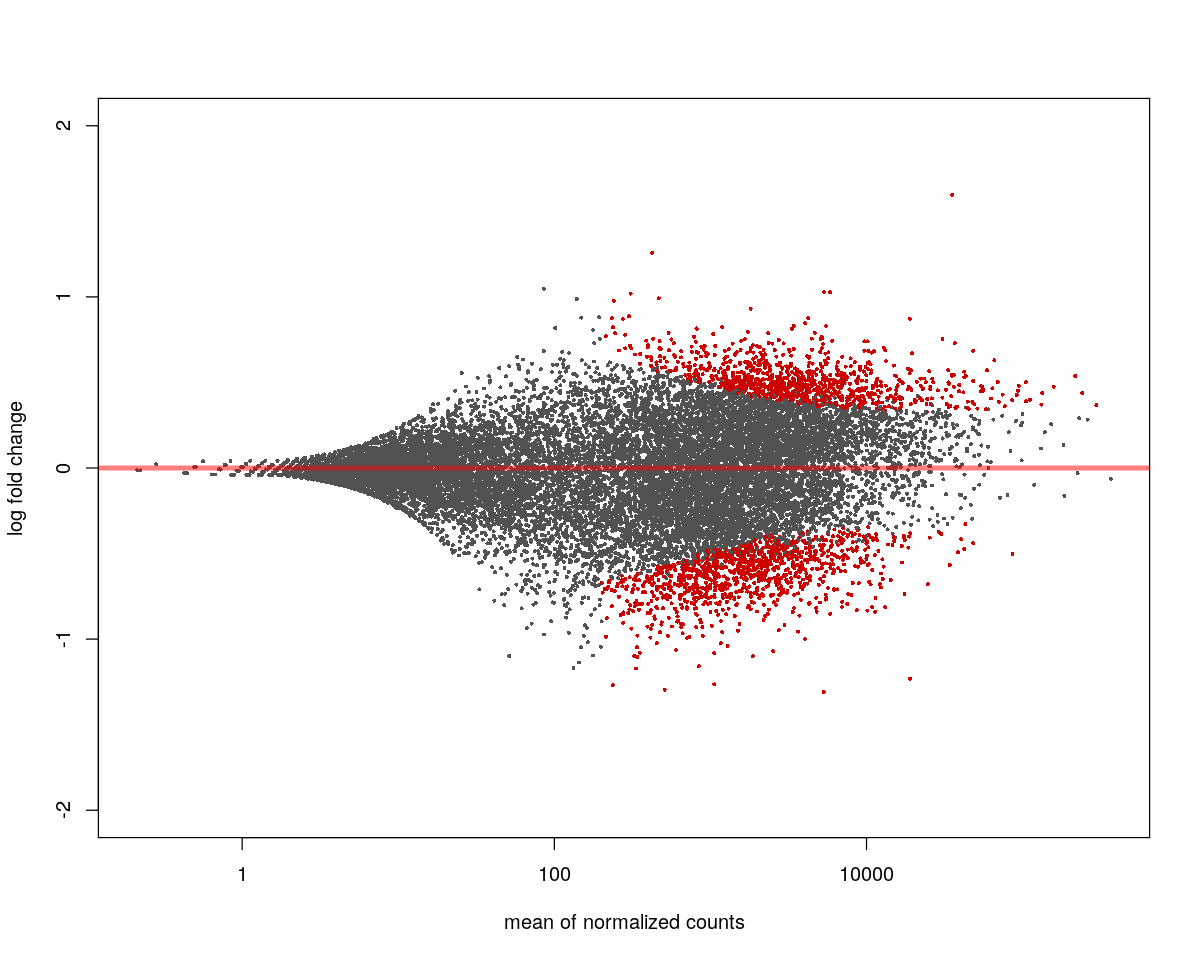

In [128]:
DESeq2::plotMA(res_shr, ylim=c(-2,2))

Many of the rows present an padj of NA, because they correspond to genes with low counts (52%) and that have been filtered out by the independentFiltering of DESeq2. I have played around with the options for the independentFiltering, for example I can change the threshold of the baseMean value after which the pvalue is set to NA.  

Notice that the package already filters out those genes that have a zero total read counts, which would be the genes for which there are 0 reads that correspond to in all of the four conditions. We need to remember that we are in a statistical context and that we are considering a single "screenshot" for a single moment in time; therefore, even a sum 0 in counts only might mean that the gene was not expressed in that moment in time or that maybe is small and was not picked up by the sequencing.

In [129]:
library(dplyr)
head(res) %>% data.frame()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIR1302-11,3.366613,-5.3915909,4.112874,-1.3109058,0.1898896,NA
RP11-34P13.7,3.022190,4.8714870,3.812997,1.2776007,0.2013903,NA
AL627309.1,20.661011,0.8735541,1.641661,0.5321162,0.5946455,NA
RP11-34P13.13,10.623531,1.2860252,1.854589,0.6934286,0.4880406,NA
AP006222.2,7.569524,3.6412378,2.384843,1.5268249,0.1268046,NA
RP4-669L17.10,7.588643,-1.5054158,2.419240,-0.6222680,0.5337657,NA


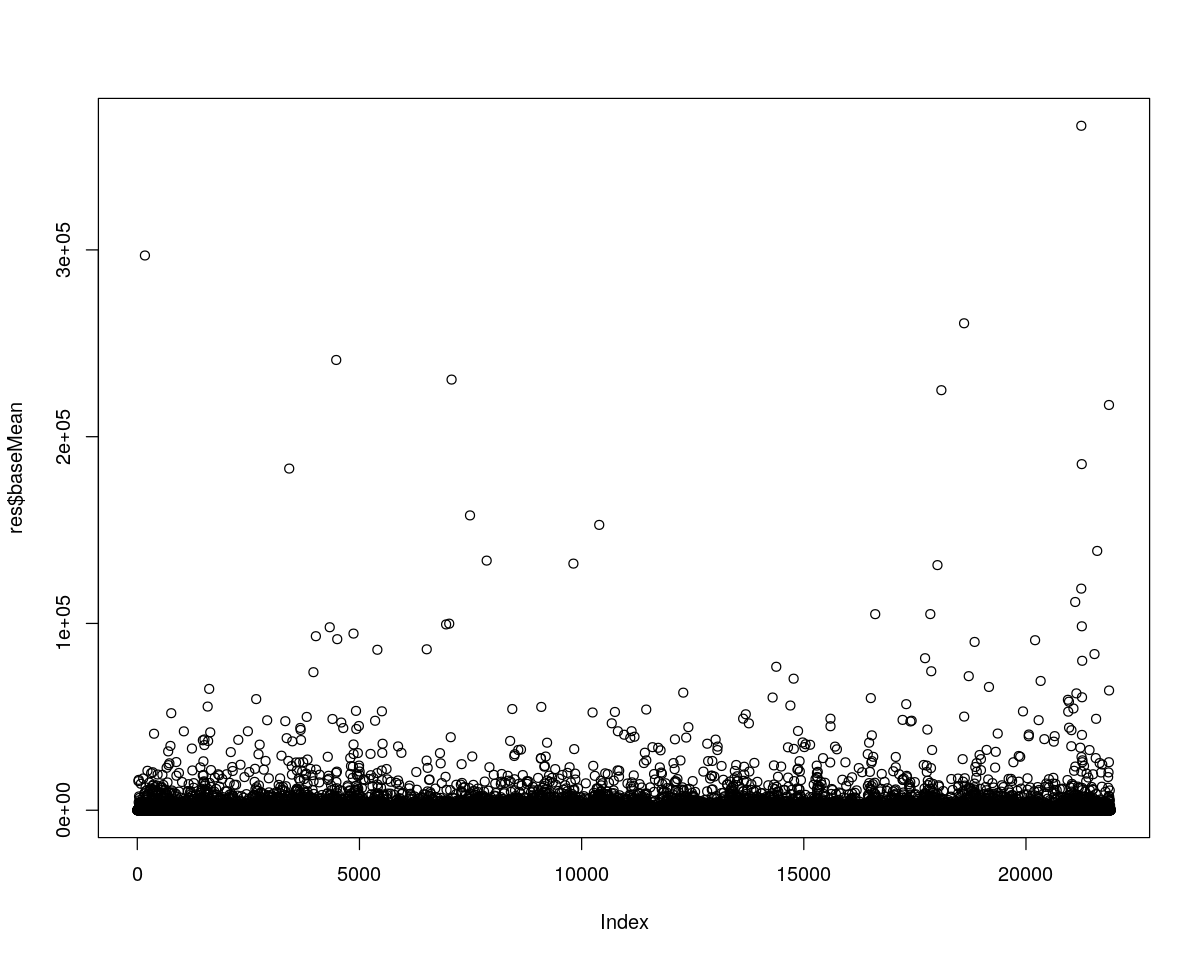

In [57]:
plot(res$baseMean)

In [97]:
res2<-results(dds, independentFiltering=FALSE)
res2$pvalue[res$baseMean < 10] <- NA
res2$padj <- p.adjust(res2$pvalue, method="BH")
summary(res2)


out of 21906 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 996, 4.5%
LFC < 0 (down)     : 792, 3.6%
outliers [1]       : 6466, 30%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



The number of genes with at least a significant double change in expression changes depending on the filtering that is applied.

In [103]:
nrow(res[(res$log2FoldChange > 1) & (!is.na(res$padj)) & (res$padj < 0.05), ])
nrow(res2[(res2$log2FoldChange > 1) & (!is.na(res2$padj)) & (res2$padj < 0.05), ])

[1] 118

[1] 181

In [104]:
nrow(res[(res$log2FoldChange < -1) & (!is.na(res$padj)) & (res$padj < 0.05), ])
nrow(res2[(res2$log2FoldChange < -1) & (!is.na(res2$padj)) & (res2$padj < 0.05), ])

[1] 18

[1] 32

In [54]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
dim(res.sign)

[1] 1203    6

I also check the distribution for the p-values and adjusted p-values.

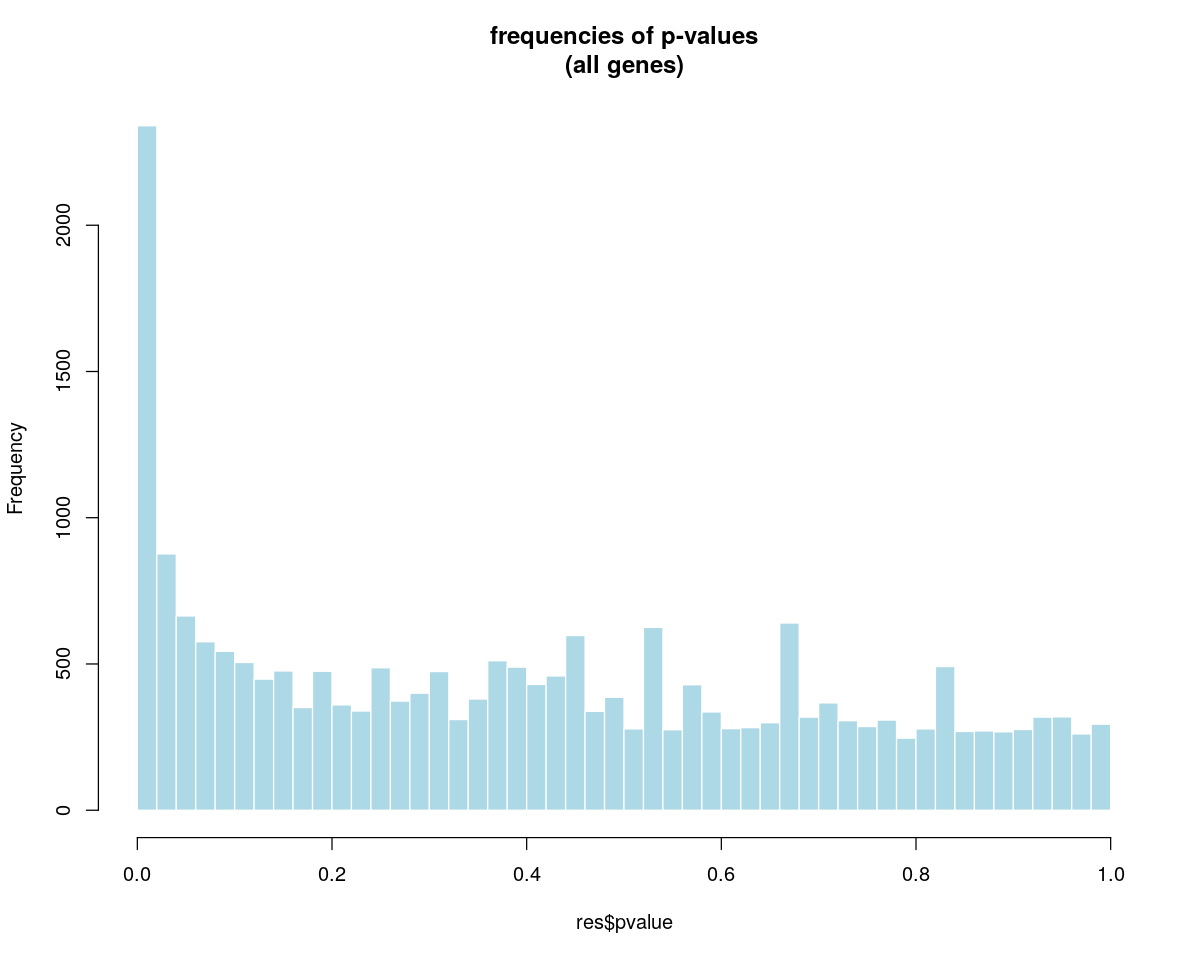

In [114]:
hist(res$pvalue, breaks=40, col="lightblue", border="white", main="Frequencies of p-values\n(all genes)")

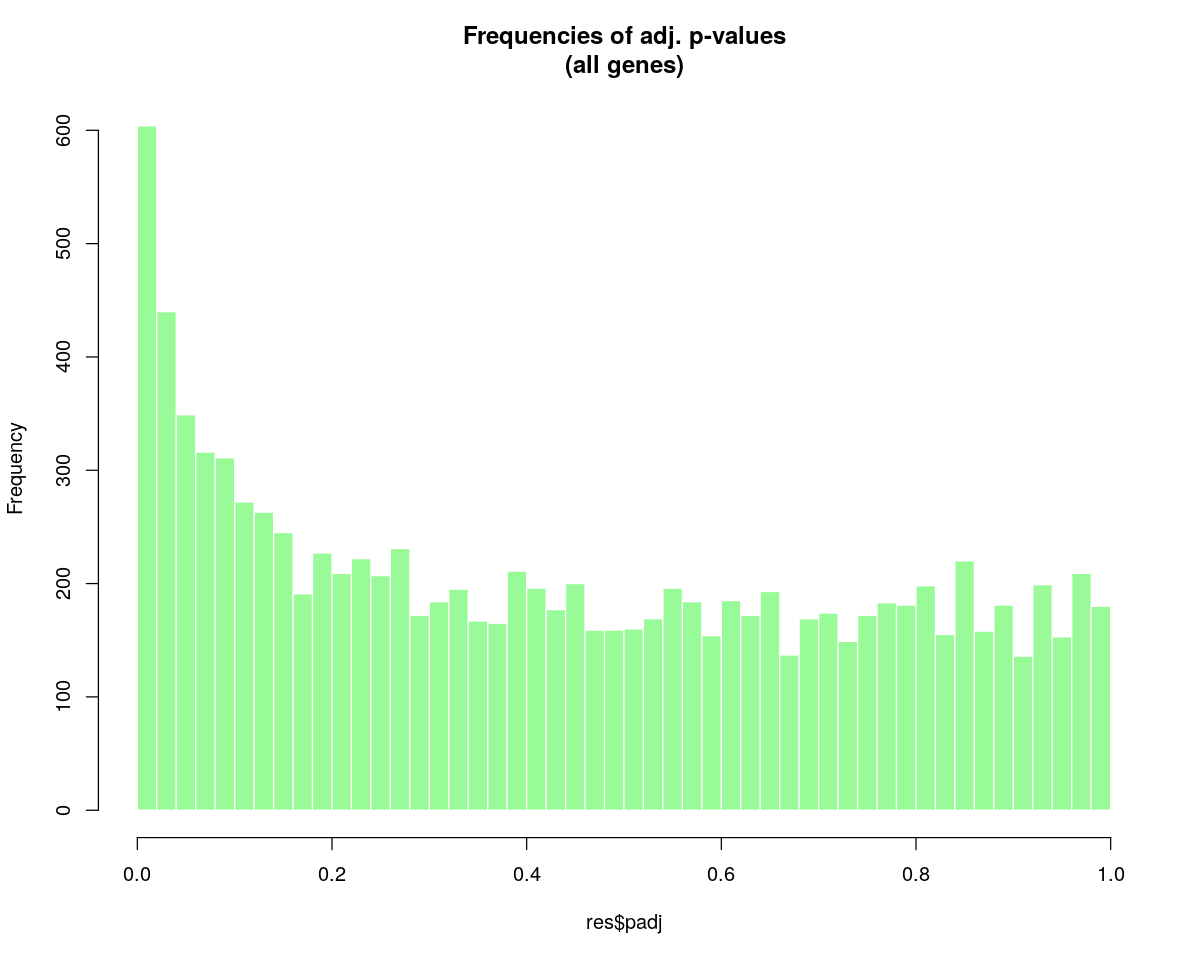

In [118]:
hist(res$padj, breaks=40, col="palegreen", border="white", main="Frequencies of adj. p-values\n(all genes)")

Notice that the different filtering is impacting also some of the most interesting genes, because they are lowly expressed. For instance:
- NAIP
- MMP13
- COL2A1
- BMP7

In [134]:
res['NAIP','padj']
res2['NAIP','padj']
res['MMP13','padj']
res2['MMP13','padj']

[1] NA

[1] 0.4717351

[1] NA

[1] 0.011965

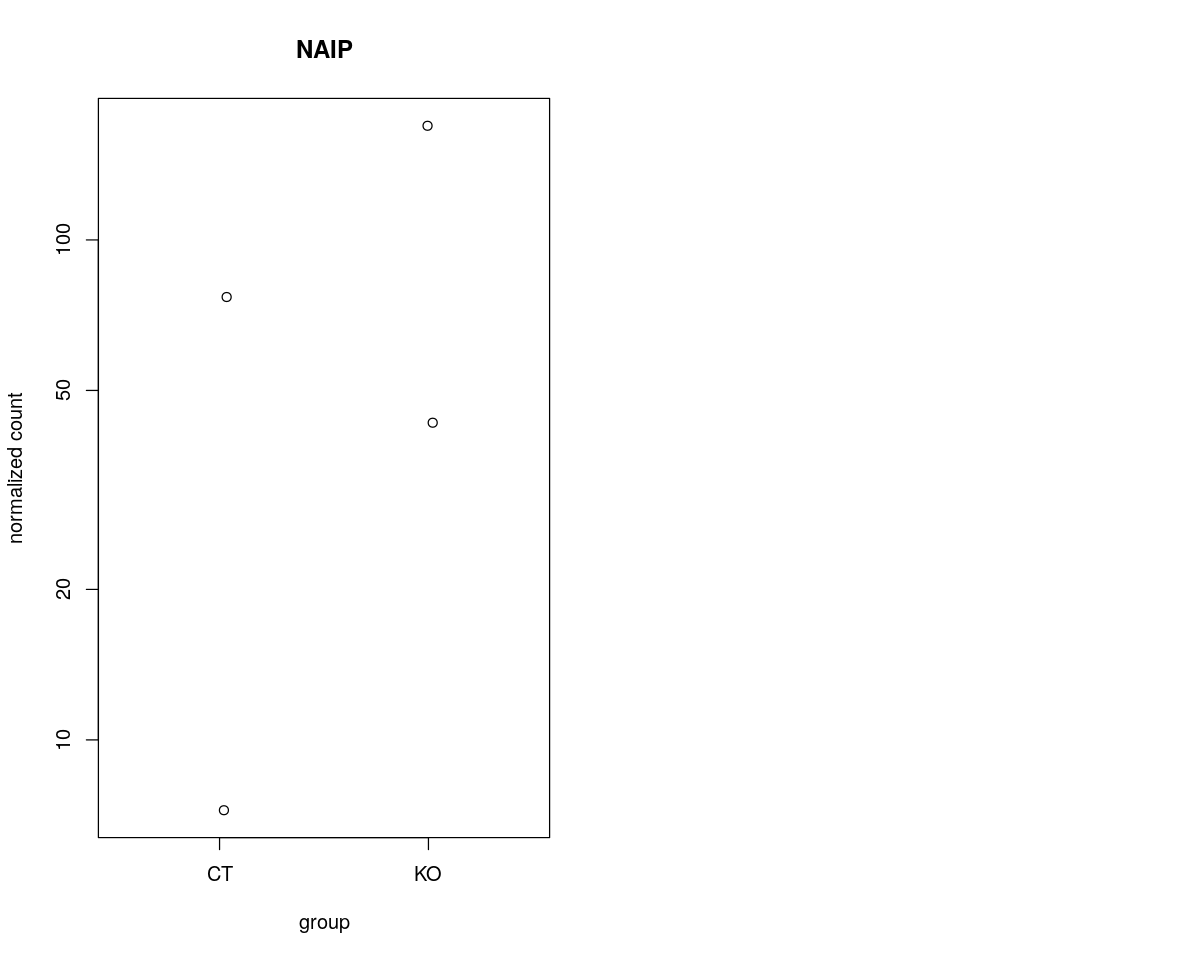

In [119]:
par(mfrow=c(1,2))
plotCounts(dds, gene="NAIP", normalized = TRUE)

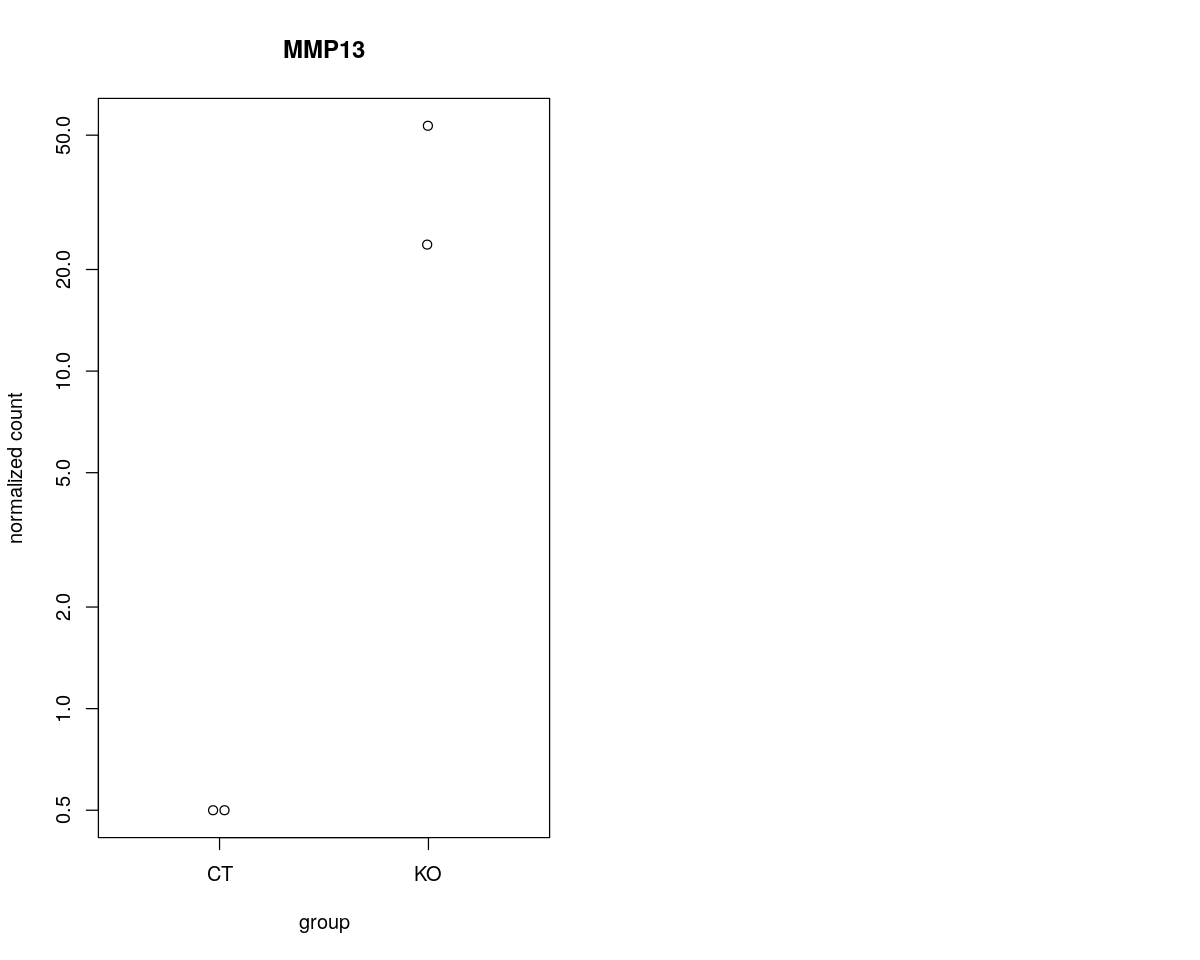

In [87]:
par(mfrow=c(1,2))
plotCounts(dds, gene="MMP13", normalized = TRUE)

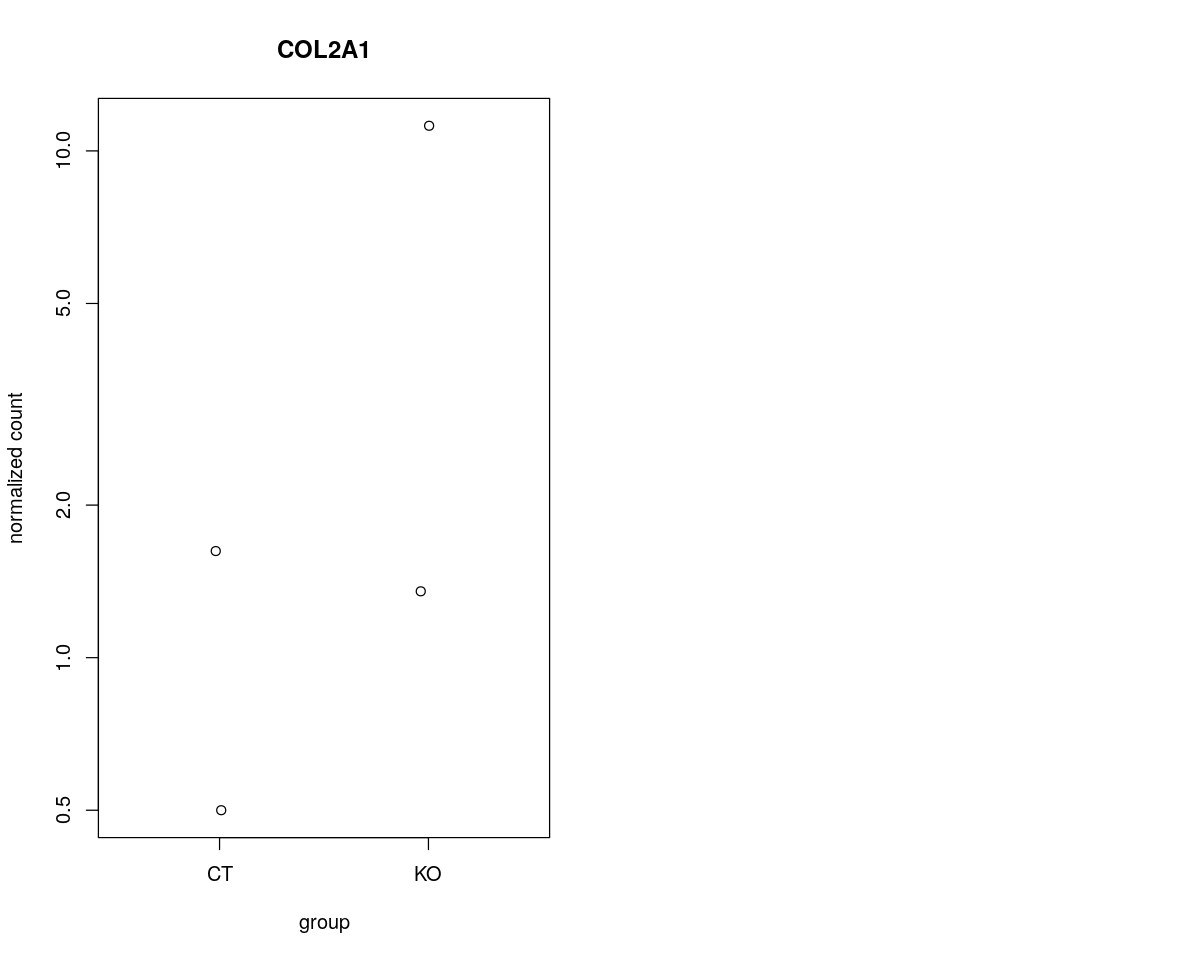

In [135]:
par(mfrow=c(1,2))
plotCounts(dds, gene="COL2A1", normalized = TRUE)

At this point, I needed to choose whetever to keep the independent filtering that DESeq had performed, or try to "save" those genes that had a lower expression level. I decided to maintain the indipendentFiltering, which gives me the certainty to obtain significant results. Even though some of the interesting genes mentioned above will be excluded from the analysis, I might still be able to find interesting relation among those genes whose differential expression is more significant (and that have a higher level of expression and more counts). 

The res table will therefore be used for the next step.

A heatplot of the differentially expressed genes is also provided below.

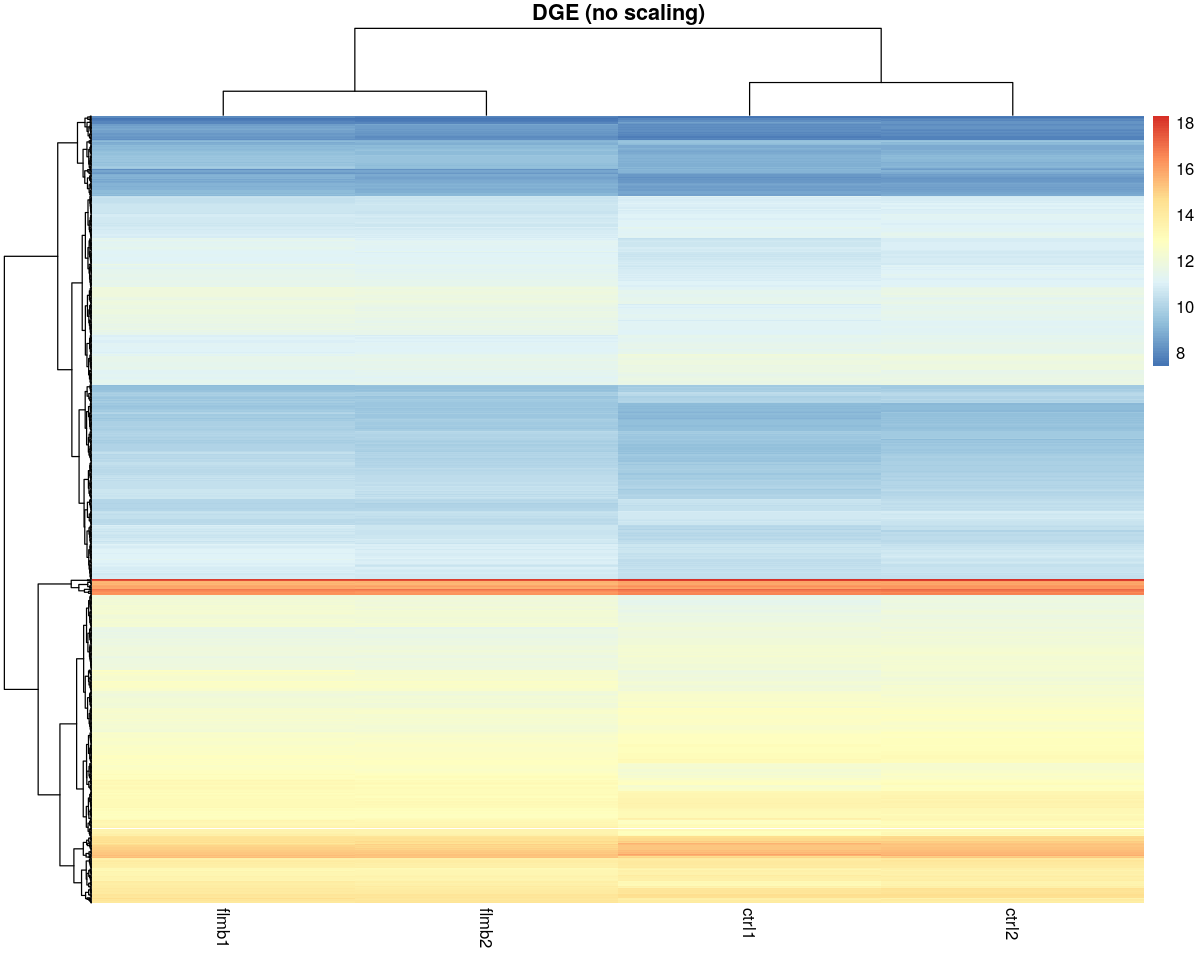

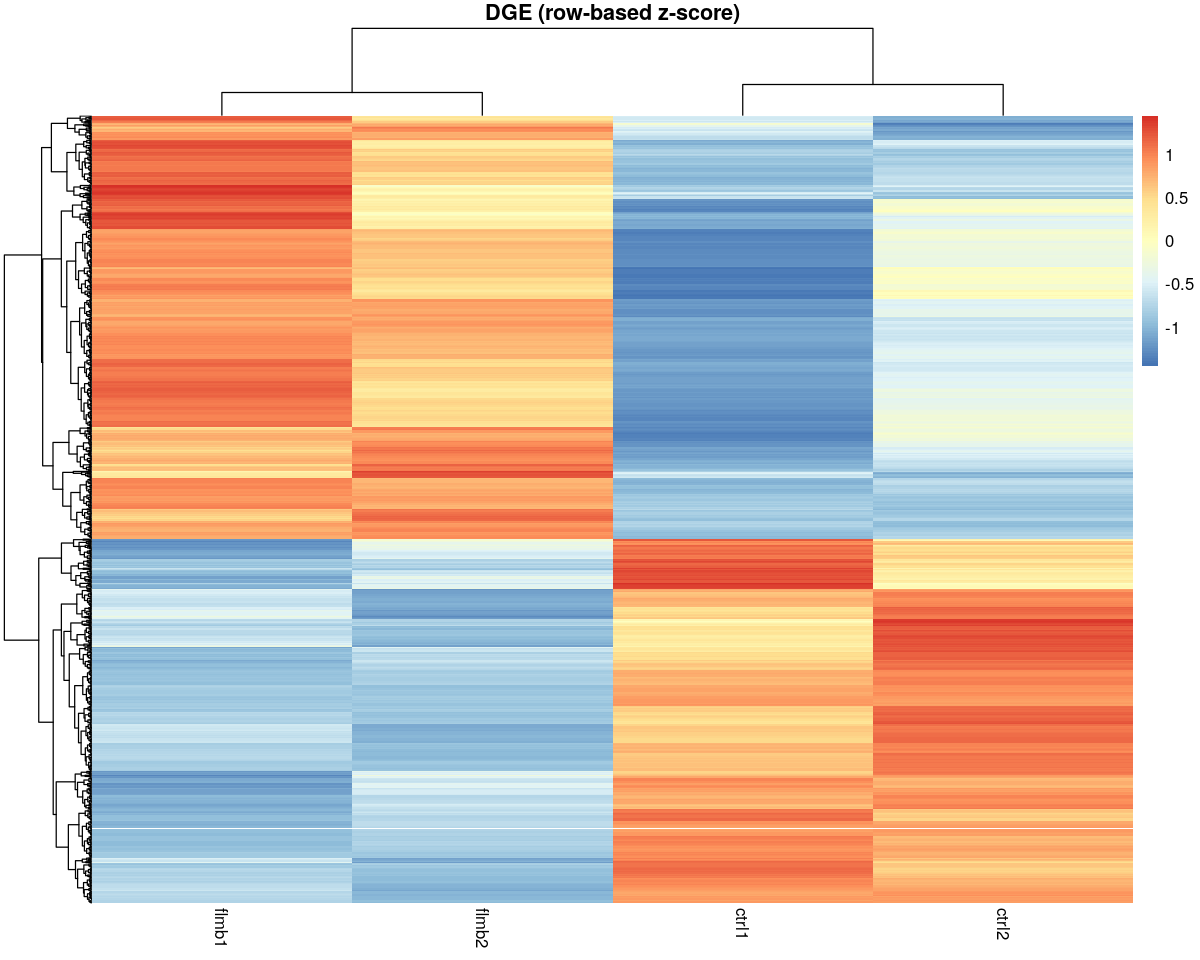

In [75]:
res.sorted <- res[order(res$padj),]
DGEgenes <- rownames(subset(res.sorted, padj < 0.05))

rlog.norm.counts<-assay(rlog(dds))
hm.mat_DGEgenes <- rlog.norm.counts[DGEgenes,]

library(pheatmap)
pheatmap(hm.mat_DGEgenes, scale="none", show_rownames = FALSE, main = "DGE (no scaling)")
pheatmap(hm.mat_DGEgenes, scale="row", show_rownames = FALSE, main = "DGE (row-based z-score)")

The results of the DESeq analysis are writted to file for subsequent functional analysis.

In [89]:
write.table(res, "deseq.trimmed.results.tsv", sep="\t", col.names=NA, quote=FALSE)